# NLP test

In [13]:
import sqlite3
import matplotlib.pyplot as plt
import pickle
import janome
import sklearn
import numpy as np
import pandas as pd
import collections
import sqlite3
import re
% matplotlib inline

In [14]:
# DB保存
conn = sqlite3.connect('reviews.sqlite3')
cur = conn.cursor()

cur.execute("select content from spams")
obj = cur.fetchall()

conn.commit()
conn.close()

In [24]:
# 形態素解析Mecab + neologd版
import MeCab

mecab = MeCab.Tagger ('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')

# art="080-3322-9382に電話かけてください"
res = []
for art in obj:
    art = art[0]
    mecab.parse("")
    res.append((len(mecab.parse(art).split())-1)/2)

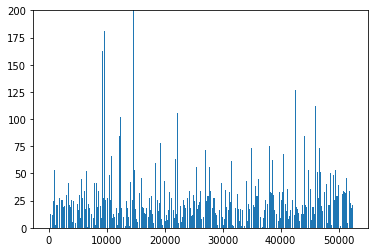

In [29]:
plt.figure()
plt.bar(np.arange(len(res)),res)
plt.ylim(0,200)
plt.show()

In [31]:
print(np.mean(np.array(res)),np.std(np.array(res)),np.min(np.array(res)),np.max(np.array(res)))

31.1362605747 38.4226533099 0.0 1410.0


In [30]:
whitelist = "\n「」。、あいうえおかきくけこさしすせそたちつてとなにぬねのはひふへほまみむめもやゐゆゑよらりるれろわをんがぎぐげござじずぜぞだぢづでどばびぶべぼぱぴぷぺぽぁぃぅぇぉゃゅょっゎ"
whitelist = set(whitelist)

In [62]:
# # 形態素解析Mecab + neologd版
# import MeCab
# import jaconv

# mecab = MeCab.Tagger ('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')

# all_word = []
# for art in obj:
#     art = art[0]
#     mecab.parse("")    
    
#     node = mecab.parseToNode(art)
    
#     while node:
#         #単語を取得
#         word = node.surface
#         #品詞を取得
#         pos = node.feature.split(",")

#         #print(word,pos,jaconv.kata2hira(pos[-1]))

#         if pos[0] != '記号':
#             word = jaconv.kata2hira(pos[-2])
#             if (set(word) - whitelist) == set():
#                 all_word.append(jaconv.kata2hira(pos[-2]))
            
#         #次の単語に進める
#         node = node.next


In [119]:
# 形態素解析Mecab + neologd版
import MeCab
import jaconv

mecab = MeCab.Tagger ('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')

all_data = []
for art in obj[:5000]:
    art = art[0]
    mecab.parse("")    
    
    node = mecab.parseToNode(art)
    
    tmp_data = []
    while node:
        #単語を取得
        word = node.surface
        #品詞を取得
        pos = node.feature.split(",")

        #print(word,pos,jaconv.kata2hira(pos[-1]))

        if pos[0] != '記号':
            word = jaconv.kata2hira(pos[-2])
            if (set(word) - whitelist) == set():
                tmp_data.append(jaconv.kata2hira(pos[-2]))
            
        #次の単語に進める
        node = node.next
    all_data.append(tmp_data)

In [180]:
all_word = []
for s in all_data:
    all_word.extend(s)
    
# 全単語ベクトル
word_id_dict = {k:v for v,k in enumerate(list(set(all_word)))}
id_word_dict = {k:v for v,k in word_id_dict.items()}
word_num = len(word_id_dict)

with open("corpus.txt","w") as f:
    for i in all_word:
        f.write(i+" ")

# word2vec
from gensim.models import word2vec

sentences = word2vec.Text8Corpus('corpus.txt')
# data = word2vec.Text8Corpus()
# model = word2vec.Word2Vec(sentences, size=200)

model = word2vec.Word2Vec(sentences,
                          sg=1,
                          size=100,
                          min_count=1,
                          window=10,
                          hs=1,
                          negative=0)


In [178]:
print(all_word[1])

みんしん


In [179]:
model['みんしん']

array([-0.06270535,  0.05742932, -0.18660608,  0.08661562, -0.03349836,
       -0.17218903, -0.17439428,  0.16034184,  0.0748358 , -0.00934489,
       -0.07770372, -0.05576156,  0.05544303, -0.11310041,  0.03485117,
        0.06962713,  0.03963358, -0.19240229, -0.06706159, -0.07378142,
       -0.09940714, -0.16995445,  0.07002343,  0.01135876,  0.00695495,
       -0.01796231,  0.02756656, -0.02378875,  0.05158627,  0.01075506,
        0.08605603, -0.01648081, -0.12147248, -0.05820456, -0.03798171,
        0.08780378, -0.04778417,  0.01342857, -0.03400591, -0.0328886 ,
       -0.00632148, -0.11414722,  0.14017501, -0.08616932,  0.00798782,
       -0.13047653, -0.02349295, -0.08817768, -0.01068511,  0.04443356,
        0.10761057,  0.25305647,  0.12275232,  0.00821608, -0.1350119 ,
       -0.0314321 ,  0.01636938,  0.03131957,  0.07892325, -0.01130211,
        0.06968971,  0.16006562,  0.01543447, -0.00317911,  0.09200123,
       -0.1197762 , -0.07383221,  0.10751411, -0.05572353,  0.05

In [183]:
x_data = []
y_data = []
for s in all_data:
    s_len = len(s)
    if s_len < 4:
        continue
    trigram = []
    next_word = []
    for i in range(s_len - 4):
        trigram.append(s[i:i+3])
        next_word.append(word_id_dict[s[i+3]])
    x_data.extend([[model[y] for y in x] for x in trigram])
    y_data.extend(next_word)
x_data = np.array(x_data)
y_data = np.array(y_data)

In [184]:
print(np.array(x_data).shape)
print(np.array(y_data).shape)
print(len(word_id_dict))

(88604, 3, 100)
(88604,)
8760


In [186]:
# x_train = x_data[:10000].reshape(10000,3,1)
# y_train = y_data[:10000]
# x_test = x_data[10000:12000].reshape(2000,3,1)
# y_test = y_data[10000:12000]

x_train = np.array(x_data)

y_train = y_data

from keras.utils import np_utils

nb_classes = len(word_id_dict)

# x_train = np_utils.to_categorical(y_train, nb_classes)
# x_test = np_utils.to_categorical(y_test, nb_classes)

Y_train = np_utils.to_categorical(y_train, nb_classes)
# Y_test = np_utils.to_categorical(y_test, nb_classes)
print(Y_train.shape)
print(x_train.shape)


(88604, 8760)
(88604, 3, 100)


In [139]:
print(x_data.shape)
x_train = x_data.reshape(x_data.shape[0],3,1)
print(x_train.shape)

(88604, 3)
(88604, 3, 1)


In [188]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

model = Sequential()
model.add(LSTM(128, input_shape=( 3, 100)))
model.add(Dense(word_num))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_8 (Dense)              (None, 8760)              1130040   
_________________________________________________________________
activation_8 (Activation)    (None, 8760)              0         
Total params: 1,247,288
Trainable params: 1,247,288
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, Y_train, batch_size=1024, epochs=5)

Epoch 1/5
87040/88604 [============================>.] - ETA: 2s - loss: 6.3679 - acc: 0.0636

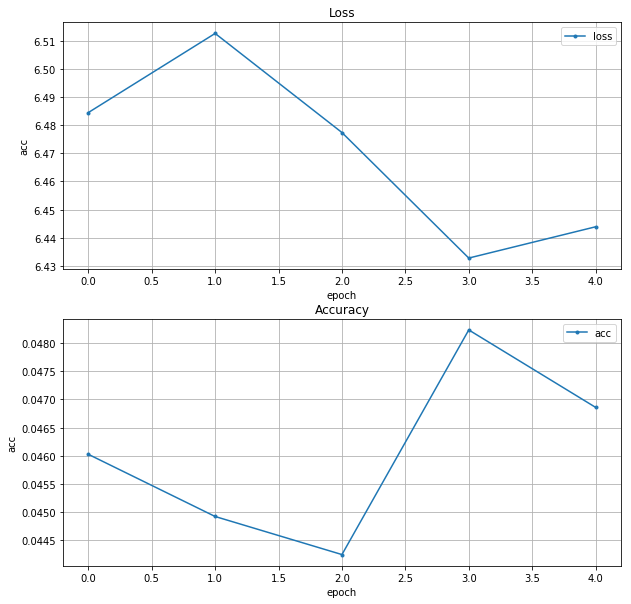

In [147]:
# 学習の様子をプロット
loss = history.history['loss']
# val_loss = history.history['val_loss']

acc = history.history['acc']
# val_acc = history.history['val_acc']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
# plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
# plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()